https://arxiv.org/abs/2310.16121

https://github.com/abogatskiy/PELICAN-nano

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
def load():
    df = pd.read_hdf("/home/nikolai/data/TopTagingML/train.h5", key="table", stop=100000)
    # list of arrays representation (without the padding)
    arrays = [x[~(x==0).all(axis=-1)] for x in df.iloc[:, :200*4].to_numpy().reshape(-1, 200, 4)]
    y = df.is_signal_new.to_numpy()
    return arrays, y

In [ ]:
arrays, y = load()

In [ ]:
len(arrays)

In [ ]:
p4 = arrays[0]
p4.shape

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, arrays, y):
        self.arrays = arrays
        self.y = y

    def __len__(self):
        return len(self.arrays)

    def __getitem__(self, i):
        return self.arrays[i], self.y[i]

In [ ]:
ds = Dataset(arrays, y)

In [ ]:
def collate_fn(batch):
    maxlen = max(len(x) for x, y in batch)
    out = torch.zeros(len(batch), maxlen, 4, dtype=torch.float32)
    mask = torch.zeros(len(batch), maxlen, dtype=bool)
    for i, (x, y) in enumerate(batch):
        out[i, :len(x)] = torch.from_numpy(x)
        mask[i, len(x):] = True
    return {"x": out, "y": torch.tensor([y for x, y in batch], dtype=torch.float32), "mask": mask}

In [ ]:
dl = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
batch = next(iter(dl))

In [ ]:
batch["x"].shape, batch["y"].shape, batch["mask"].shape

In [ ]:
bx = batch["x"]

In [ ]:
prod = bx[:, :, np.newaxis] * bx[:, np.newaxis, :]
prod.shape

In [ ]:
dot2 = prod[..., 0] - prod[..., 1:].sum(axis=-1)
dot2.shape

In [ ]:
len(dot2.ravel())

In [ ]:
logdot2 = torch.log(1 + dot2)

In [ ]:
plt.hist(logdot2.ravel().numpy(), bins=100);
#plt.yscale("log")

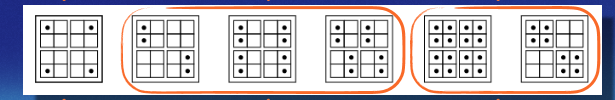

from [ML4Jets2024 slides](https://indico.cern.ch/event/1253794/contributions/5588625/attachments/2748386/4783069/ML4Jets23_PELICAN.pdf)

In [ ]:
logdot2.shape

In [ ]:
# sf
np.mean([len(x) for x in arrays])

In [ ]:
sf = 1 / 50

In [ ]:
rowsum = logdot2.sum(axis=1, keepdim=True) * sf
rowsum.shape

In [ ]:
totsum = logdot2.sum(axis=(1, 2), keepdim=True) * sf**2
totsum.shape

In [ ]:
N = batch["x"].shape[1]
N

In [ ]:
rowsum

In [ ]:
totsum.expand(-1, N, -1).squeeze(-1)

In [ ]:
agg0 = logdot2
agg1 = rowsum.expand(-1, N, -1)
agg2 = agg1.transpose(-1, -2)
agg3 = torch.diag_embed(rowsum.squeeze(1))
agg4 = totsum.expand(-1, N, N)
agg5 = torch.diag_embed(totsum.expand(-1, N, -1).squeeze(-1))

In [ ]:
agg3.shape

In [ ]:
def six_aggs(x, sf=1/50):
    rowsum = x.sum(axis=1, keepdim=True) * sf
    totsum = x.sum(axis=(1, 2), keepdim=True) * sf**2
    N = x.shape[1]
    aggs = []
    aggs.append(x)
    aggs.append(rowsum.expand(-1, N, -1))
    aggs.append(aggs[0].transpose(-1, -2))
    aggs.append(torch.diag_embed(rowsum.squeeze(1)))
    aggs.append(totsum.expand(-1, N, N))
    aggs.append(torch.diag_embed(totsum.expand(-1, N, -1).squeeze(-1)))
    return torch.stack(aggs, -1)

In [ ]:
aggs = six_aggs(logdot2)
aggs.shape

In [ ]:
sq_mask = batch["mask"][:, :, np.newaxis] | batch["mask"][:, np.newaxis, :]
sq_mask[0]

In [ ]:
sq_mask.shape

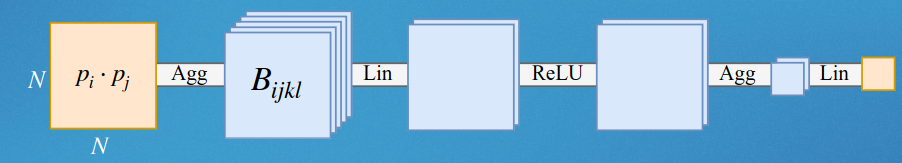

In [ ]:
c = nn.Linear(6, 2)(aggs).relu().masked_fill(sq_mask[..., np.newaxis], 0)
c.shape

In [ ]:
ft = torch.cat([(c.sum((1, 2)) * sf**2), c.diagonal(dim1=1, dim2=2).sum(-1)], -1)
ft.shape

In [ ]:
nn.Linear(4, 1)(ft).sigmoid()

In [ ]:
class NanoPelican(nn.Module):
    def __init__(self, sf=1/50):
        super().__init__()
        self.linear1 = nn.Linear(6, 2)
        self.linear2 = nn.Linear(4, 1)
        self.sf = sf

    def forward(self, x, mask):
        mask = mask[:, :, np.newaxis] | mask[:, np.newaxis, :] # squared mask
        mask = mask[..., np.newaxis]
        x = x[:, :, np.newaxis] * x[:, np.newaxis, :] # pairwise prod
        x = x[..., 0] - x[..., 1:].sum(axis=-1) # minkowski dot squared
        x = torch.log(1 + x)
        x = six_aggs(x, sf=self.sf)
        x = self.linear1(x).relu().masked_fill(mask, 0)
        x = torch.cat([x.sum((1, 2)) * sf**2, x.diagonal(dim1=1, dim2=2).sum(-1) * sf], -1)
        x = self.linear2(x).sigmoid()
        return x

In [ ]:
model = NanoPelican()

In [ ]:
model(batch["x"], batch["mask"])

In [ ]:
sum(par.numel() for par in model.parameters())

In [ ]:
ds_train, ds_val = torch.utils.data.random_split(ds, [0.9, 0.1])
kwargs = dict(batch_size=32, collate_fn=collate_fn)
dl_train = DataLoader(ds_train, shuffle=True, **kwargs)
dl_val = DataLoader(ds_val, **kwargs)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from tqdm.auto import tqdm

In [ ]:
history = []

In [ ]:
def fit(model, optimizer, dl_train, dl_val, history, epochs=1):
    loss_fn = F.binary_cross_entropy_with_logits
    def forward(model, batch):
        return model(batch["x"], batch["mask"]).squeeze()

    def train_step(batch):
        model.train()
        optimizer.zero_grad()
        logits = forward(model, batch)
        loss = loss_fn(logits, batch["y"])
        loss.backward()
        optimizer.step()
        return loss.cpu().detach().item()

    def val_step(batch):
        model.eval()
        with torch.no_grad():
            logits = forward(model, batch)
            return loss_fn(logits, batch["y"]).cpu().item()

    for epoch in range(epochs):
        losses = []
        for batch in tqdm(dl_train):
            losses.append(train_step(batch))
        val_losses = []
        for batch in dl_val:
            val_losses.append(val_step(batch))
        history.append({"loss": np.mean(losses), "val_loss": np.mean(val_losses)})
        print(history[-1])

    return losses

In [ ]:
fit(model, optimizer, dl_train, dl_val, history, epochs=5)

In [ ]:
pd.DataFrame(history).plot()

In [ ]:
def evaluate(model, dl):
    y_pred = []
    model.eval()
    for batch in tqdm(dl):
        with torch.no_grad():
            y_pred.append(model(batch["x"], mask=batch["mask"]).sigmoid().squeeze(1))
    return torch.cat(y_pred)

In [ ]:
y_pred = evaluate(model, DataLoader(ds, batch_size=32, collate_fn=collate_fn))

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr, tpr, thr = roc_curve(y, y_pred.numpy())
auc(fpr, tpr)

In [ ]:
plt.plot(tpr, 1 / fpr)
plt.yscale("log")
(1 / fpr)[tpr>0.3].max()